# QGS model: MAOOAM

## Coupled ocean-atmosphere model version

This model version is a 2-layer channel QG atmosphere truncated at wavenumber 2 coupled, both by friction and heat exchange, to a shallow water ocean with 8 modes. 

More details can be found in the articles:
* Vannitsem, S., Demaeyer, J., De Cruz, L., & Ghil, M. (2015). *Low-frequency variability and heat transport in a low-order nonlinear coupled ocean–atmosphere model*. Physica D: Nonlinear Phenomena, **309**, 71-85. [doi:10.1016/j.physd.2015.07.006](https://doi.org/10.1016/j.physd.2015.07.006)
* De Cruz, L., Demaeyer, J. and Vannitsem, S. (2016). *The Modular Arbitrary-Order Ocean-Atmosphere Model: MAOOAM v1.0*, Geosci. Model Dev., **9**, 2793-2808. [doi:10.5194/gmd-9-2793-2016](https://doi.org/10.5194/gmd-9-2793-2016)

or in the documentation and on [readthedocs](https://qgs.readthedocs.io/en/latest/files/model/maooam_model.html).

## Modules import

First, setting the path and loading of some modules

In [1]:
import sys, os

In [2]:
sys.path.extend([os.path.abspath('../')])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Times'],'size':12})

Initializing the random number generator (for reproducibility). -- Disable if needed.

In [5]:
np.random.seed(210217)

Importing the model's modules

In [6]:
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator
from qgs.functions.tendencies import create_tendencies

and diagnostics

In [7]:
from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic, OceanicLayerStreamfunctionDiagnostic
from qgs.diagnostics.temperatures import MiddleAtmosphericTemperatureDiagnostic, OceanicLayerTemperatureDiagnostic
from qgs.diagnostics.variables import VariablesDiagnostic, GeopotentialHeightDifferenceDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic

## Systems definition

General parameters

In [8]:
# Time parameters
dt = 0.1
# Saving the model state n steps
write_steps = 100

number_of_trajectories = 1

Setting some model parameters

In [9]:
# Model parameters instantiation with some non-default specs
model_parameters = QgParams()

# Mode truncation at the wavenumber 2 in both x and y spatial
# coordinates for the atmosphere
model_parameters.set_atmospheric_channel_fourier_modes(2, 2)
# Mode truncation at the wavenumber 2 in the x and at the 
# wavenumber 4 in the y spatial coordinates for the ocean
model_parameters.set_oceanic_basin_fourier_modes(2, 4)

In [10]:
# Setting MAOOAM parameters according to the publication linked above
model_parameters.set_params({'kd': 0.0290, 'kdp': 0.0290, 'n': 1.5, 'r': 1.e-7,
                             'h': 136.5, 'd': 1.1e-7})
model_parameters.atemperature_params.set_params({'eps': 0.7, 'T0': 289.3,
                                                 'hlambda': 15.06})
model_parameters.gotemperature_params.set_params({'gamma': 5.6e8, 'T0': 301.46})

Setting the short-wave radiation component as in the publication above: $C_{\text{a},1}$ and $C_{\text{o},1}$ 


In [11]:
model_parameters.atemperature_params.set_insolation(103.3333, 0)
model_parameters.gotemperature_params.set_insolation(310, 0)

Printing the model's parameters

In [12]:
model_parameters.print_params()

Qgs v0.2.5 parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 1.5    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.25    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.029  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.029  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 103.3333  [W][m^-2]  (spectral component 1 of the short-wave radiation 

Creating the tendencies function

In [13]:
%%time
f, Df = create_tendencies(model_parameters)

CPU times: user 12.9 s, sys: 854 ms, total: 13.7 s
Wall time: 12.7 s


## Time integration

Defining an integrator

In [14]:
integrator = RungeKuttaIntegrator()
integrator.set_func(f)

Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors 

In [15]:
%%time
## Might take several minutes, depending on your cpu computational power.
ic = np.random.rand(model_parameters.ndim)*0.01
integrator.integrate(0., 3000000., dt, ic=ic, write_steps=0)
time, ic = integrator.get_trajectories()

CPU times: user 197 ms, sys: 251 ms, total: 447 ms
Wall time: 4min 18s


Now integrate to obtain a trajectory on the attractor

In [16]:
%%time
integrator.integrate(0., 500000., dt, ic=ic, write_steps=write_steps)
reference_time, reference_traj = integrator.get_trajectories()

CPU times: user 83.2 ms, sys: 82 ms, total: 165 ms
Wall time: 45 s


Plotting the result in 3D and 2D

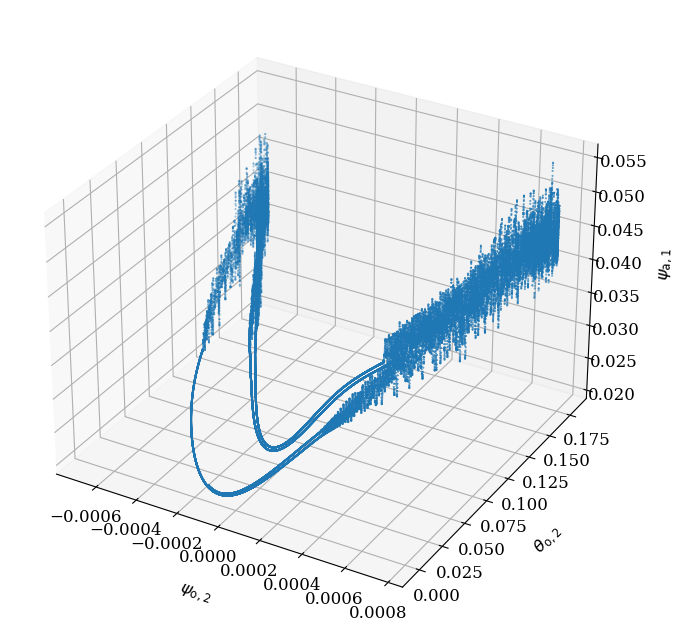

In [17]:
varx = 21
vary = 29
varz = 0

fig = plt.figure(figsize=(10, 8))
axi = fig.add_subplot(111, projection='3d')

axi.scatter(reference_traj[varx], reference_traj[vary], reference_traj[varz], s=0.2);

axi.set_xlabel('$'+model_parameters.latex_var_string[varx]+'$', labelpad=12.)
axi.set_ylabel('$'+model_parameters.latex_var_string[vary]+'$', labelpad=12.)
axi.set_zlabel('$'+model_parameters.latex_var_string[varz]+'$', labelpad=12.);

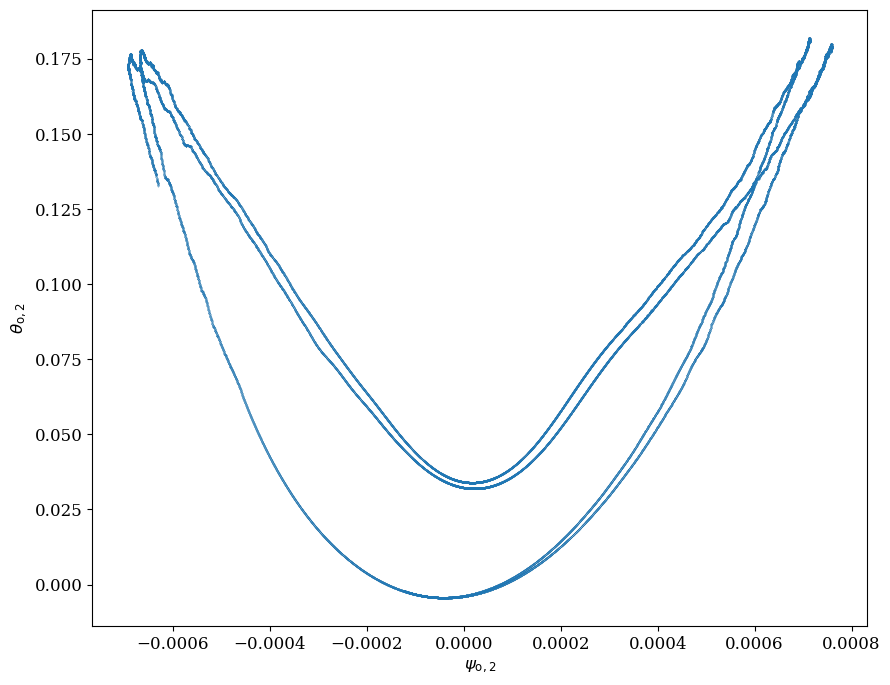

In [18]:
varx = 21
vary = 29
plt.figure(figsize=(10, 8))

plt.plot(reference_traj[varx], reference_traj[vary], marker='o', ms=0.1, ls='')

plt.xlabel('$'+model_parameters.latex_var_string[varx]+'$')
plt.ylabel('$'+model_parameters.latex_var_string[vary]+'$');

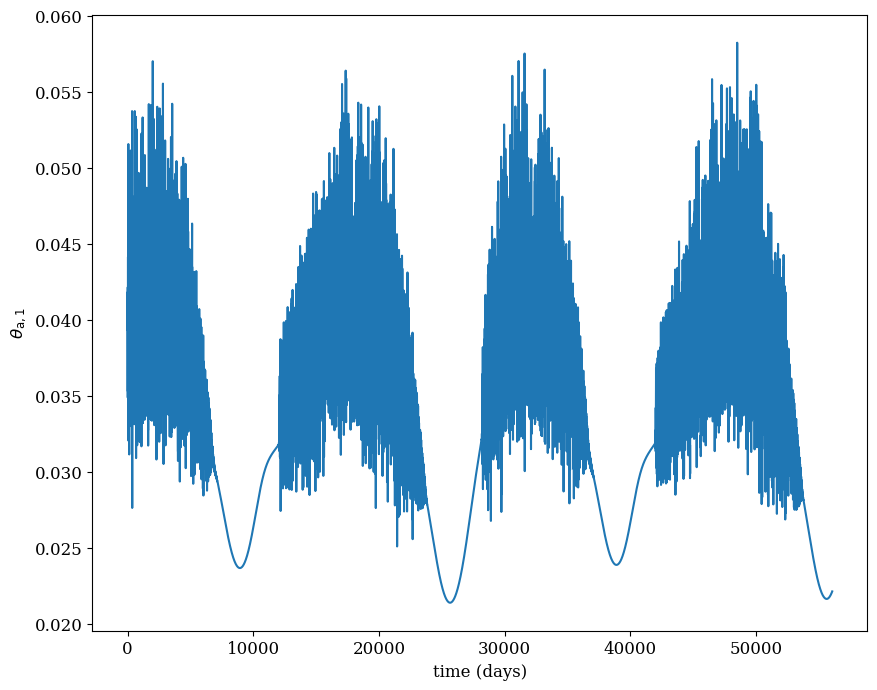

In [19]:
var = 10
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*reference_time, reference_traj[var])

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

## Showing the resulting fields (animation)

This is an advanced feature showing the time evolution of diagnostic of the model. It shows simultaneously a scatter plot of the variables $\psi_{{\rm a}, 1}$, $\psi_{{\rm o}, 2}$ and $\theta_{{\rm o}, 2}$, with the corresponding atmospheric and oceanic streamfunctions and temperature at 500 hPa. Please read the documentation for more information.

Creating the diagnostics:

* For the 500hPa geopotential height:

In [20]:
psi_a = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, geopotential=True)

* For the 500hPa atmospheric temperature:

In [21]:
theta_a = MiddleAtmosphericTemperatureDiagnostic(model_parameters)

* For the ocean streamfunction:

In [22]:
psi_o = OceanicLayerStreamfunctionDiagnostic(model_parameters)

* For the ocean temperature:

In [23]:
theta_o = OceanicLayerTemperatureDiagnostic(model_parameters)

* For the nondimensional variables $\psi_{{\rm a}, 1}$, $\psi_{{\rm o}, 2}$ and $\theta_{{\rm o}, 2}$:

In [24]:
variable_nondim = VariablesDiagnostic([21, 29, 0], model_parameters, False)

* For the geopotential height difference between North and South:

In [25]:
geopot_dim = GeopotentialHeightDifferenceDiagnostic([[[np.pi/model_parameters.scale_params.n, np.pi/4], [np.pi/model_parameters.scale_params.n, 3*np.pi/4]]],
                                                    model_parameters, True)


In [26]:
# setting also the background
background = VariablesDiagnostic([21, 29, 0], model_parameters, False)
background.set_data(reference_time, reference_traj)

Selecting a subset of the data to plot:

In [27]:
stride = 10
time = reference_time[10000:10000+5200*stride:stride]
traj = reference_traj[:, 10000:10000+5200*stride:stride]

Creating a multi diagnostic with all the diagnostics:

In [28]:
m = MultiDiagnostic(2,3)
m.add_diagnostic(geopot_dim, diagnostic_kwargs={'style':'moving-timeserie'})
m.add_diagnostic(theta_a, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(theta_o, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(variable_nondim, diagnostic_kwargs={'show_time':False, 'background': background, 'style':'3Dscatter'}, plot_kwargs={'ms': 0.2})
m.add_diagnostic(psi_a, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(psi_o, diagnostic_kwargs={'show_time':False})

m.set_data(time, traj)

and show an interactive animation:

In [29]:
rc('font',**{'family':'serif','sans-serif':['Times'],'size':12})
m.animate(figsize=(23,12))

interactive(children=(IntSlider(value=2000, description='time_index', max=4000), Output()), _dom_classes=('wid…

or a movie (may takes some minutes to compute):

CPU times: user 7min 35s, sys: 5min 32s, total: 13min 7s
Wall time: 3min 48s


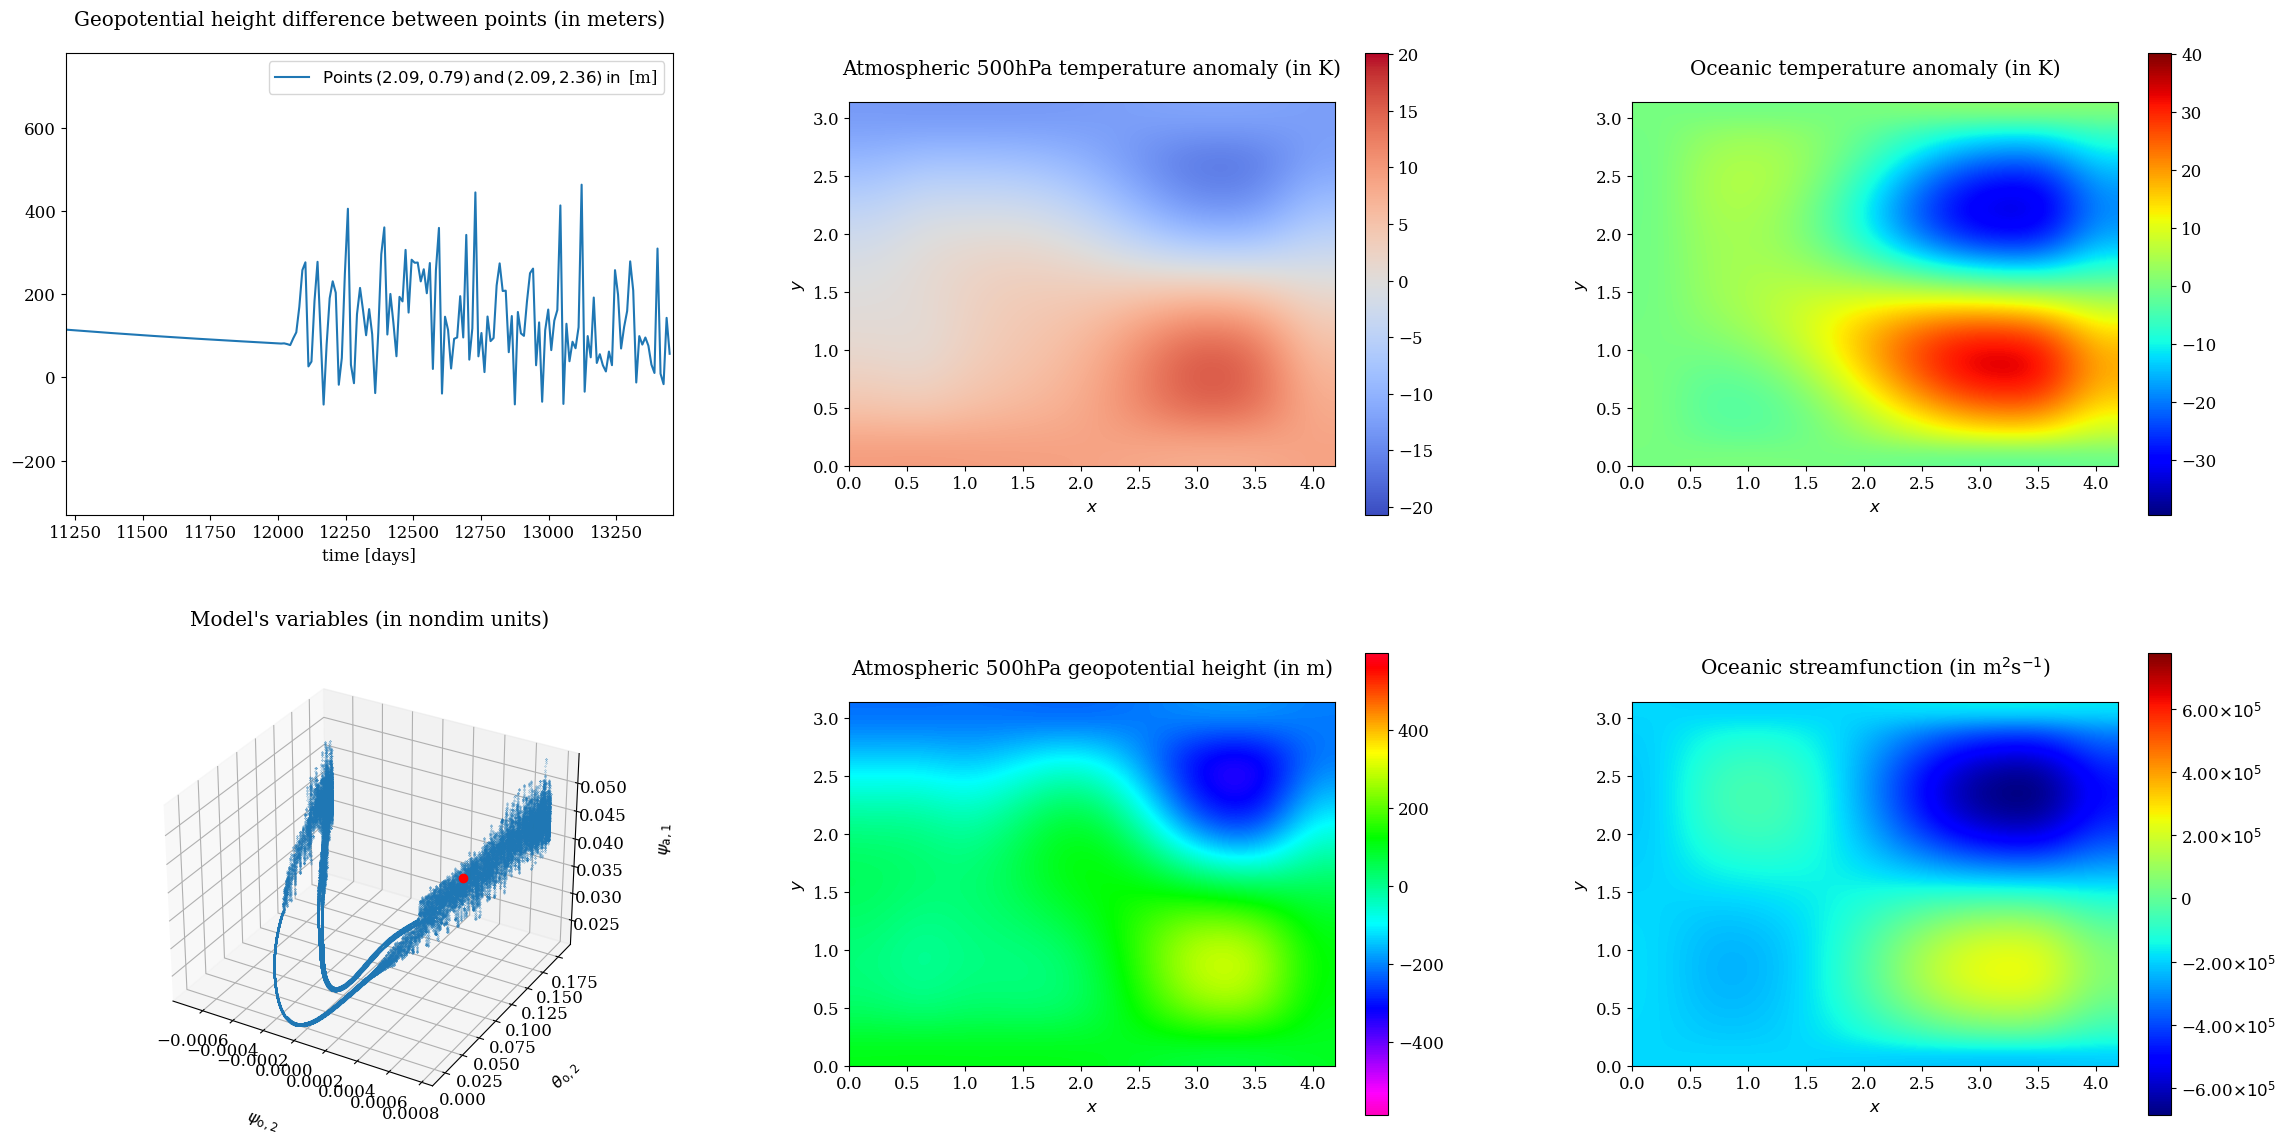

In [31]:
%%time
rc('font',**{'family':'serif','sans-serif':['Times'],'size':12})
m.movie(figsize=(23.5,12), anim_kwargs={'interval': 10, 'frames':200})